# PaddleOCR

## Clone source code về (Paddle OCR)

In [ ]:
!git clone https://github.com/anminhhung/PaddleOCR-VN

Cloning into 'PaddleOCR-VN'...
remote: Enumerating objects: 340, done.
remote: Counting objects: 100% (340/340), done.
remote: Compressing objects: 100% (284/284), done.
remote: Total 340 (delta 52), reused 331 (delta 48), pack-reused 0
Receiving objects: 100% (340/340), 13.56 MiB | 38.89 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [ ]:
%cd /content/PaddleOCR-VN

/content/PaddleOCR-VN


### Cài đặt thư viện cần thiết

In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install paddlepaddle-gpu

In [ ]:
!nvidia-smi

Cả hai phần ***detect*** và ***recognize*** đều gồm các bước sau:

Bước 1: Tiền xử lý dữ liệu <br>
Bước 2: Cấu hình file config <br>
Bước 3: Train model <br>
Bước 4: Evaluation <br>
Bước 5: Convert sang model inference <br>
Bước 6: Predict <br>

In [ ]:
# Downloading dataset
# !wget https://github.com/usuyama/ePillID-benchmark/releases/download/ePillID_data_v1.0/ePillID_data.zip
!gdown --id 1kVj567d7ZtzyC4wFw_TJkK-KFEVkkATB

In [ ]:
!unzip /content/PaddleOCR-VN/ePillID_data.zip

## Model Detection (SAST)

SAST (A Single-Shot Arbitrarily-Shaped Text Detector based on Context Attended Multi-Task Learning) là một mô hình hiệu quả trong việc dự đoán văn bản có hình dạng tùy ý tuy nhiên các vùng chữ nhỏ đang là vấn đề với nó.

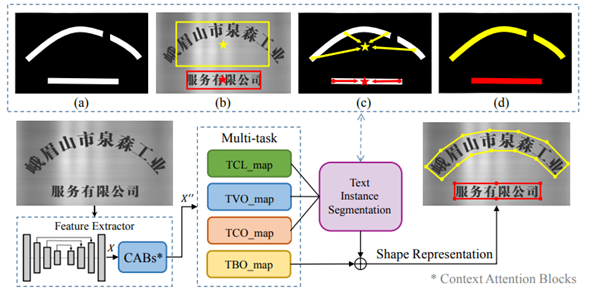

### Tiền xử lý dữ liệu, convert về format của PaddleOCR để train:

Để train model detection PaddleOCR, file annotation cần có format như sau:



> Image file name_____________Image annotation information encoded by json.dumps”

> img_001.jpg_________________[{“transcription”: “text”, “points”: [[310, 104], [416, 141], [418, 216], [312, 179]]}, {…}]



Ở đây
* points sẽ là các cặp (x, y) 4 góc của text box theo chiều ngược kim đồng hồ, bắt đầu từ góc dưới bên trái.
* transcription là text ở trong text box hiện tại. Khi chứa “###” thì có nghĩa là text box này invalid và sẽ skip đi khi train model.

Quan sát tập dữ liệu ta thấy:
* Folder labels chứa từng file annotation cho mỗi ảnh.
* Mỗi dòng trong file annotation chứa một text box.
* Các cặp points được xếp theo chiều ngược kim đồng hồ và bắt đầu từ góc dưới bên trên và tách nhau bởi dấu phẩy, cuối cùng là text của box đó.


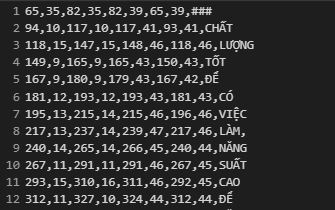

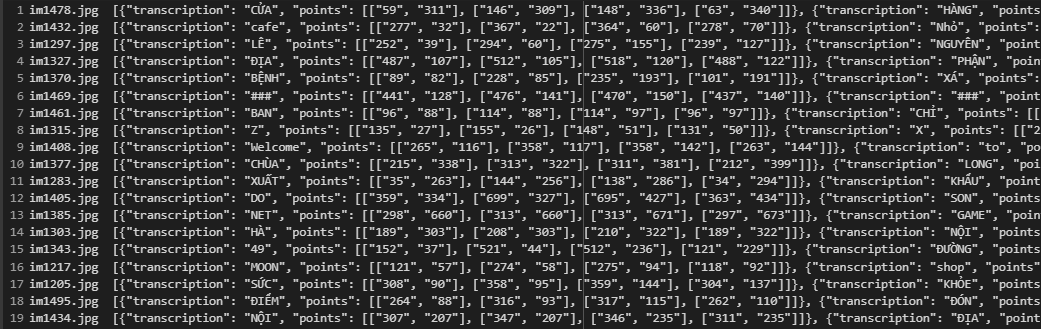

### Chuẩn bị file config

Trong bước này chọn model detection để sử dụng.

SAST đạt hiệu quả tốt nhất cho nên sử dụng SAST với Backbone là ResNet50_vd trong cuộc thi này.

Sau khi quyết định được mô hình sẽ sử dụng, download pretrained model đã được train sẵn với dataset tiếng anh đạt kết quả cao với ICDAR2015 dataset.

Download Pretrained Model

Vào link sau đây và download pretrained SAST + ResNet50_vd:
https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/doc/doc_en/algorithm_overview_en.md

### Download pretrain model SAST


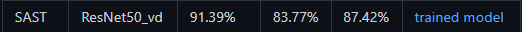

In [ ]:
!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/en/det_r50_vd_sast_icdar15_v2.0_train.tar -P ./pretrain_models
!tar -xf ./pretrain_models/det_r50_vd_sast_icdar15_v2.0_train.tar -C /content/drive/MyDrive/Scene_TextVN/pretrain_models

### Traning

In [ ]:
!python3 tools/train.py -c ./configs/det/SAST.yml

Chú thích

Global:
* use_gpu: sử dụng gpu hoặc không
* epoch_num: số epoch tối đa khi train .
* save_model_dir: là đường dẫn thư mục lưu checkpoint cho mỗi epoch khi train.
* pretrained_model: là đường dẫn thư mục pretrained model.
* checkpoints: là đường dẫn thư mục load checkpoint khi train.

Train:
* data_dir: là đường dẫn thư mục chứa ảnh train
* label_file_list: list các file annotation
* ratio_list: tỉ lệ train data set



---



Trong dòng code trên, sử dụng -c để chọn file cấu hình. Ngoài ra bạn còn có thể sử dụng -o để thay đổi các parameter mà không cần phải sửa file yml.

Sau mỗi save_epoch_step, checkpoint sẽ được lưu ở đường dẫn được đặt tại dòng Global.save_model_dir trong file config gồm 3 file:

* iter_epoch_1.pdopt
* iter_epoch_1.pdparams
* iter_epoch_1.states

Ví dụ ta có thể train tiếp từ checkpoint trên mà không cần sửa file config bằng cách sau:

In [ ]:
!python3 tools/train.py -c ./configs/det/SAST.yml    \
    -o Global.checkpoints=./output/SAST/iter_epoch_26

Chú thích: Global.checkpoints sẽ được ưu tiên hơn Global.pretrained_model do đó nếu cả 2 đều được set thì Global.checkpoints sẽ được load để train. Nếu đường dẫn Global.checkpoints sai, Global.pretrained_model sẽ được load.

## Model Recognition (SRN)

SRN (Semantic Reasoning Network) kết hợp cả phần visual information và global semantic information, hai phần này chạy song song trong quá trình huấn luyện và đưa ra kết quả.

SRN là một end-to-end trainable pipeline cho bài toán scene text recognition, bao gồm 4 phần:

* Backbone network
* Parallel visual attention module (PVAM)
* Global semantic reasoning module (GSRM)
* Visual semantic fusion decoder (VSFD)

Pipeline: Khi đưa ảnh đầu vào, đầu tiên, backbone network sẽ được dùng để trích xuất các thuộc tính 2D (V). Sau đó, PVAM được dùng để tạo ra N thuộc tính 1D sau khi được căn chỉnh, tại đó, mỗi thuộc tính tương ứng với một ký tự trong văn bản. N thuộc tính 1D này sau đó sẽ được đưa vào GSRM để thu thập thông tin ngữ nghĩa (S). Cuối cùng, các thuộc tính ảnh sau khi được căn chỉnh và ngữ nghĩa của nó sẽ được VSFD hợp nhất để dự đoán các ký tự.

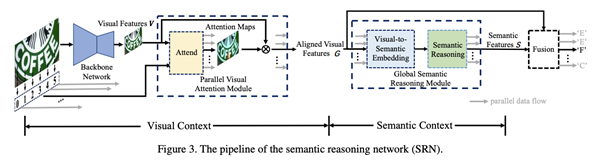

### Chuẩn bị dữ liệu

Data train model recognition thì nó sẽ khác so với model detection đó là data sẽ là các ảnh nhỏ và một file txt lưu đường dẫn ảnh cùng với chữ trong ảnh đó.

Format data

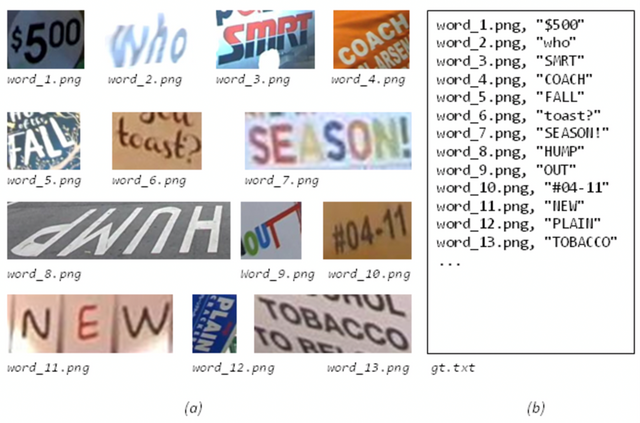

Có thể thấy rằng data để train model recognition là mỗi ảnh chứa một chữ trong khi data đã download lại là ảnh chứa nhiều chữ. Do vậy ta phải cắt nhỏ ảnh đã có từ các box chứa text.

### Dictionary

Để dự đoán được tiếng việt thì ta cũng cần một file dictionary dành cho tiếng Việt chứa tất cả các kí tự. Vì PaddleOCR chưa hỗ trợ tiếng Việt nên phải tự làm một file dictionary riêng để train. Dictionary được lưu ở ppocr/utils/dict/vi_vietnam.txt.

### Chuẩn bị file config

Cách chỉnh sửa file config model recognition cũng tương tự như model detection. Chỉ có một số điểm khác là character_dict_path – đường dẫn file dictionary,   use_space_char – dự đoán khoảng trắng hay không, max_text_length – độ dài tối đa kí tự trong một box.

### Training

In [ ]:
# !python3 tools/train.py -c ./configs/rec/SRN.yml \
#            -o Global.use_gpu=True \
#            Global.pretrained_model=pretrained_model \
#            Global.character_type = ch

In [ ]:
!python3 tools/train.py -c ./configs/rec/SRN.yml

## Evaluation

Một bước không thể thiếu đó là đánh giá mô hình để biết mô hình có đang hoạt động tốt không, chuyện gì xảy ra với mô hình. Từ đó giúp ta xác định được nên làm gì tiếp theo. Dataset dùng để evaluation được set ở mục Eval.dataset trong file config.

In [ ]:
#evaluation model detect
!python3 /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/tools/eval.py -c /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/configs/det/SAST.yml \
                       -o Global.checkpoints_model=path_checkpoints

In [ ]:
#evaluation model recognition
!python3 /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/tools/eval.py -c /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/configs/rec/SRN.yml  \
                   -o Global.checkpoints=path_checkpoints \
                      Global.character_type=ch  \
                       Global.character_dict_path=/content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/ppocr/utils/dict/vi_vietnam.txt

##  Inference với model đã train xong

Cả 2 model detection và recognition được convert như sau:

In [ ]:
# !python3 tools/export_model.py -c ./configs/det/SAST.yml  \
#                               -o Global.pretrained_model= #path_pretrained \
#                                  Global.save_inference_dir=./inference/SAST

In [ ]:
# !python3 tools/export_model.py -c ./configs/rec/SRN.yml  \
#                               -o Global.pretrained_model= #path_pretrained \
#                                  Global.save_inference_dir=./inference/SRN

In [ ]:
!python3 /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/tools/infer/predict_det.py --det_algorithm="SAST" --use_gpu=True \
                                   --det_model_dir="/content/drive/MyDrive/Scene_TextVN/inference/SAST"  \
                                   --image_dir=/content/drive/MyDrive/Scene_TextVN/train/vietnamese/test_image/

In [ ]:
!python3 /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/tools/infer/predict_rec.py --image_dir="/content/drive/MyDrive/Scene_TextVN/train/vietnamese/test_image/im1201.jpg" \
                             --use_gpu=True \
                                   --rec_algorithm="SRN" \
                                   --rec_model_dir="/content/drive/MyDrive/Scene_TextVN/inference/SRN/"  \
                                   --rec_image_shape="1, 64, 256"  \
                                   --rec_char_type="ch"   \
                                   --rec_char_dict_path="/content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/ppocr/utils/dict/vi_vietnam.txt"

## Kết hợp hai model detection và recognition với nhau:

Cuối cùng kết hợp cả hai model detection và recognition với nhau để predict ra kết quả:

In [ ]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

In [ ]:
%cd /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese

/content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.5 MB 5.1 MB/s 
     |████████████████████████████████| 948 kB 58.2 MB/s 
     |████████████████████████████████| 604 kB 69.0 MB/s 
     |████████████████████████████████| 2.8 MB 57.9 MB/s 
     |████████████████████████████████| 50 kB 7.4 MB/s 
     |████████████████████████████████| 55.7 MB 1.1 MB/s 
     |████████████████████████████████| 204 kB 72.8 MB/s 
     |████████████████████████████████| 399 kB 71.7 MB/s 
     |████████████████████████████████| 2.3 MB 49.5 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149867 sha256=a2423de3153051dbc981f0b527258f8b87ca09b1caf9e179f7e0f9c6bee324a4
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein
  Attempting uninstall: scikit-image
    Found ex

In [ ]:
!pip install paddlepaddle-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 393.8 MB 26 kB/s 
     |████████████████████████████████| 394 kB 65.9 MB/s 


In [ ]:
!python3 /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/tools/infer/predict_system.py --use_gpu=True  \
           --det_algorithm="SAST"  \
           --det_model_dir="/content/drive/MyDrive/Scene_TextVN/inference/SAST"  \
           --rec_algorithm="SRN" \
           --rec_model_dir="/content/drive/MyDrive/Scene_TextVN/inference/SRN/"  \
           --rec_image_shape="1, 64, 256"  \
           --image_dir="/content/drive/MyDrive/AI4VNChallenge2022/dataset/public_train/prescription/image/VAIPE_P_TRAIN_1172.png" \
           --rec_char_type="ch"  \
           --drop_score=0.7  \
           --rec_char_dict_path="/content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/ppocr/utils/dict/vi_vietnam.txt"

/usr/local/lib/python3.7/dist-packages/skimage/data/__init__.py:107: DeprecationWarning: 
    Importing file_hash from pooch.utils is DEPRECATED. Please import from the
    top-level namespace (`from pooch import file_hash`) instead, which is fully
    backwards compatible with pooch >= 0.1.
    
  return file_hash(path) == expected_hash
/usr/local/lib/python3.7/dist-packages/skimage/morphology/_skeletonize.py:241: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  0, 1, 1, 0, 0, 1, 0, 0, 0], dtype=np.bool)
/usr/local/lib/python3.7/dist-packages/skimage/morphology/_skeletonize.py:256: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence t

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PadleeOCR detect

In [ ]:
%cd /content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese

/content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese


In [ ]:
!python3 tools/infer/predict_det.py --det_algorithm="SAST" --image_dir="/content/drive/MyDrive/AI4VNChallenge2022/dataset/public_train/prescription/image/VAIPE_P_TRAIN_1172.png" --det_model_dir="/content/drive/MyDrive/Scene_TextVN/inference/SAST/"

/usr/local/lib/python3.7/dist-packages/skimage/data/__init__.py:107: DeprecationWarning: 
    Importing file_hash from pooch.utils is DEPRECATED. Please import from the
    top-level namespace (`from pooch import file_hash`) instead, which is fully
    backwards compatible with pooch >= 0.1.
    
  return file_hash(path) == expected_hash
/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(key, collections.Hashable):
/usr/local/lib/python3.7/dist-packages/skimage/morphology/_skeletonize.py:241: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: h

In [ ]:
!python3 tools/infer/predict_det.py --det_algorithm="SAST" --image_dir="/content/drive/MyDrive/AI4VNChallenge2022/dataset/public_train/prescription/image/" --det_model_dir="/content/drive/MyDrive/Scene_TextVN/inference/SAST/"

/usr/local/lib/python3.7/dist-packages/skimage/data/__init__.py:107: DeprecationWarning: 
    Importing file_hash from pooch.utils is DEPRECATED. Please import from the
    top-level namespace (`from pooch import file_hash`) instead, which is fully
    backwards compatible with pooch >= 0.1.
    
  return file_hash(path) == expected_hash
/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(key, collections.Hashable):
/usr/local/lib/python3.7/dist-packages/skimage/morphology/_skeletonize.py:241: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: h

In [ ]:
!python3 tools/infer/predict_rec.py --image_dir="/content/drive/MyDrive/AI4VNChallenge2022/dataset/public_train/prescription/image/VAIPE_P_TRAIN_1172.png" --rec_model_dir="/content/drive/MyDrive/Scene_TextVN/inference/SRN/" --rec_image_shape="1,64,256" --rec_char_type="ch" --rec_algorithm="SRN" --rec_char_dict_path="/content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/ppocr/utils/dict/vi_vietnam.txt" --use_space_char=False

In [ ]:
det_detect_box = open("/content/drive/MyDrive/Scene_TextVN/PaddleOCR-Vietnamese/inference_results/det_results.txt", "r")

In [ ]:
content = det_detect_box.readlines()
det_detect_box.close()
content = [x.strip() for x in content]
text = []

In [ ]:
print(content)

['[VAIPE_P_TRAIN_1172.png],[[[325, 120], [424, 121], [423, 151], [325, 150]], [[57, 25], [113, 26], [113, 57], [58, 60]], [[438, 96], [533, 95], [532, 115], [437, 115]], [[588, 726], [664, 727], [664, 741], [589, 742]], [[84, 387], [228, 387], [225, 406], [83, 407]], [[426, 127], [507, 127], [507, 150], [427, 150]], [[490, 631], [548, 634], [549, 651], [491, 649]], [[670, 727], [730, 726], [730, 741], [670, 741]], [[259, 127], [315, 127], [318, 150], [261, 150]], [[585, 630], [635, 632], [636, 649], [585, 649]], [[306, 387], [358, 390], [355, 412], [304, 409]], [[665, 388], [708, 388], [706, 407], [664, 406]], [[124, 493], [165, 495], [166, 510], [124, 509]], [[118, 469], [163, 466], [163, 485], [119, 484]], [[239, 235], [282, 232], [282, 251], [240, 252]], [[260, 688], [316, 687], [317, 704], [261, 705]], [[230, 388], [302, 387], [300, 407], [228, 406]], [[34, 444], [71, 444], [71, 463], [34, 462]], [[127, 689], [165, 689], [165, 705], [127, 704]], [[60, 685], [99, 687], [100, 702], [

In [ ]:
content[0][0]

'['

In [ ]:
for i in content:
  label = {}
  i = i.split(',',8)
  label['transcription'] = i[-1]
  label['points'] = [[i[0],i[1]],[i[2],i[3]], [i[4],i[5]],[i[6],i[7]]]
  text.append(label)

## Visualize data

In [ ]:
import cv2
import json
import os

pill_pres_map_json_file = "/content/drive/MyDrive/AI4VNChallenge2022/dataset/public_train/pill_pres_map.json"
pres_dir = '/content/drive/MyDrive/AI4VNChallenge2022/dataset/public_train/prescription'
pill_dir = '/content/drive/MyDrive/AI4VNChallenge2022/dataset/public_train/pill'

In [ ]:
# read pill_pres_map.json
f = open('/content/drive/MyDrive/AI4VNChallenge2022/dataset/public_train/pill_pres_map.json')
data = json.load(f)

dict_label_pres = {}

print("[INFO] Processing......!")

[INFO] Processing......!


In [ ]:
for obj in data:
    for key, value in obj.items():
        if key == 'pres':
            pres_json_file = value
            pres_img_file = value.split(".")[0] + ".png"

            pres_json_path = os.path.join(pres_dir, 'label', pres_json_file)
            pres_img_path = os.path.join(pres_dir, "image", pres_img_file)

            # print("pres_json_path: ", pres_json_path)
            # json
            json_f = open(pres_json_path)
            pres_data = json.load(json_f)
            # image
            pres_image = cv2.imread(pres_img_path)

            for obj_bbox in pres_data:
                id = obj_bbox["id"]
                text = obj_bbox["text"]
                label = obj_bbox["label"]
                bbox = obj_bbox["box"]

                if label not in dict_label_pres:
                    dict_label_pres[label] = 0
                else:
                    dict_label_pres[label] = dict_label_pres[label] + 1

                # visualize
                pres_image = cv2.rectangle(pres_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 255), 1)
                text_bbox = "id: {}, text: {}, label: {}".format(id, text, label)
                pres_image = cv2.putText(pres_image, text_bbox, (bbox[0], bbox[1]), \
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

            # pres_image = cv2.resize(pres_image, (1024, 1024))
            # cv2.imshow("demo", pres_image)
            # cv2.waitKey(0)
        else:
            for pill_json_file in value:
                pill_img_file = pill_json_file.split(".")[0] + ".jpg"

                pill_json_path = os.path.join(pill_dir, 'label', pill_json_file)
                pill_img_path = os.path.join(pill_dir, "image", pill_img_file)

                 # json
                json_f = open(pill_json_path)
                pill_data = json.load(json_f)
                # image
                pill_image = cv2.imread(pill_img_path)

                for obj_bbox in pill_data:
                    x = obj_bbox["x"]
                    y = obj_bbox["y"]
                    h = obj_bbox["h"]
                    w = obj_bbox["w"]
                    label = obj_bbox["label"]

                    bbox = [x, y, x+w, y+h]
                    # visualize
                    pill_image = cv2.rectangle(pill_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 255), 1)
                    text_bbox = "label: {}".format(label)
                    pill_image = cv2.putText(pill_image, text_bbox, (bbox[0], bbox[1]), \
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

                # pill_image = cv2.resize(pill_image, (1024, 1024))
                # cv2.imshow('demo', pill_image)
                # cv2.waitKey(0)

print("[INFO] Done!")
print(dict_label_pres)

# xử lý label đơn thuốc

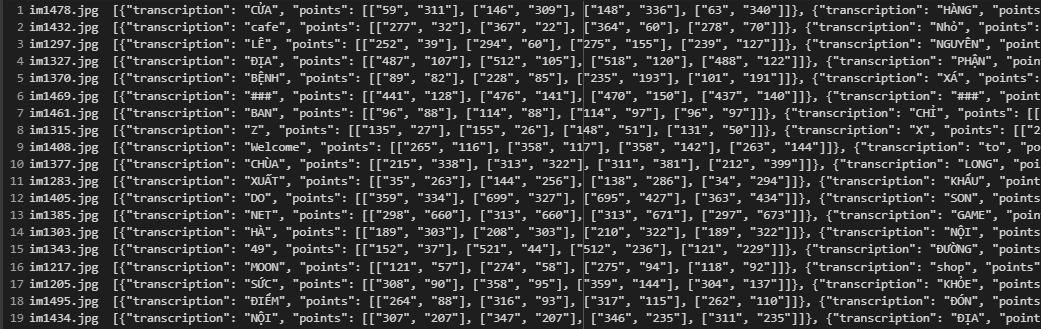

In [ ]:
import json

In [ ]:
url = open('/content/drive/MyDrive/AI4VNChallenge2022/dataset/public_train/prescription/label/VAIPE_P_TRAIN_0.json')

In [ ]:
label = json.load(url)

In [ ]:
for i in range(len(label)):
  print(label[i])

{'id': 1, 'text': '1/1', 'label': 'other', 'box': [58, 28, 113, 58]}
{'id': 3, 'text': 'LHANG', 'label': 'other', 'box': [153, 60, 208, 76]}
{'id': 4, 'text': 'Số phiếu 1646/2019', 'label': 'other', 'box': [372, 91, 535, 123]}
{'id': 5, 'text': '3648383', 'label': 'other', 'box': [626, 100, 688, 118]}
{'id': 6, 'text': 'TOA THUỐC BHYT', 'label': 'other', 'box': [260, 122, 508, 152]}
{'id': 9, 'text': 'Nam', 'label': 'other', 'box': [618, 160, 655, 177]}
{'id': 10, 'text': 'Nữ', 'label': 'other', 'box': [685, 160, 708, 177]}
{'id': 13, 'text': '35', 'label': 'other', 'box': [366, 207, 387, 224]}
{'id': 14, 'text': '208', 'label': 'other', 'box': [436, 207, 468, 225]}
{'id': 15, 'text': '07327', 'label': 'other', 'box': [509, 207, 560, 225]}
{'id': 16, 'text': '35', 'label': 'other', 'box': [300, 208, 322, 225]}
{'id': 17, 'text': 'MMHg Thân nhiệt:', 'label': 'other', 'box': [450, 231, 595, 255]}
{'id': 18, 'text': 'lần/phút Huyết áp:', 'label': 'other', 'box': [168, 232, 305, 252]}
{'id

In [ ]:
label[0]['box']

[58, 28, 113, 58]

In [ ]:
temp = [[label[2]['box'][0], label[2]['box'][1]], [label[2]['box'][2], label[2]['box'][1]], [label[2]['box'][2], label[2]['box'][3]], [label[2]['box'][0], label[2]['box'][3]]]

In [ ]:
print(temp)

[[372, 91], [535, 91], [535, 123], [372, 123]]


In [ ]:
train_label = open("train_label.txt","w")

text = []

for i in label:
  target = {}
  target['transcription'] = i['text']
  target['point'] = [[i['box'][0], i['box'][1]], [i['box'][2], i['box'][1]], [i['box'][2], i['box'][3]], [i['box'][0], i['box'][3]]]

  text.append(target)
  train_label.write(img_name+ '\t'+f'{text}' + '\n')

In [ ]:
print(text)

[{'transcription': '1/1', 'point': [[58, 28], [113, 28], [113, 58], [58, 58]]}, {'transcription': 'LHANG', 'point': [[153, 60], [208, 60], [208, 76], [153, 76]]}, {'transcription': 'Số phiếu 1646/2019', 'point': [[372, 91], [535, 91], [535, 123], [372, 123]]}, {'transcription': '3648383', 'point': [[626, 100], [688, 100], [688, 118], [626, 118]]}, {'transcription': 'TOA THUỐC BHYT', 'point': [[260, 122], [508, 122], [508, 152], [260, 152]]}, {'transcription': 'Nam', 'point': [[618, 160], [655, 160], [655, 177], [618, 177]]}, {'transcription': 'Nữ', 'point': [[685, 160], [708, 160], [708, 177], [685, 177]]}, {'transcription': '35', 'point': [[366, 207], [387, 207], [387, 224], [366, 224]]}, {'transcription': '208', 'point': [[436, 207], [468, 207], [468, 225], [436, 225]]}, {'transcription': '07327', 'point': [[509, 207], [560, 207], [560, 225], [509, 225]]}, {'transcription': '35', 'point': [[300, 208], [322, 208], [322, 225], [300, 225]]}, {'transcription': 'MMHg Thân nhiệt:', 'point'

In [ ]:
%cd /content/drive/MyDrive/AI4VNChallenge2022/dataset/public_train

/content/drive/MyDrive/AI4VNChallenge2022/dataset/public_train


In [ ]:
import glob
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import json

In [ ]:
%cd /content/drive/MyDrive/AI4VNChallenge2022/dataset/public_train/prescription

/content/drive/MyDrive/AI4VNChallenge2022/dataset/public_train/prescription


In [ ]:
f = '/content/drive/MyDrive/AI4VNChallenge2022/dataset/public_train/prescription/label/VAIPE_P_TRAIN_0.json'
img_name = os.path.basename(f).split('.')[0]
print(img_name)

VAIPE_P_TRAIN_0


In [ ]:
root_path = glob.glob('/content/drive/MyDrive/AI4VNChallenge2022/dataset/public_train/prescription/label/*')
for file in root_path:
    # print(file)
    img_name = os.path.basename(file).split('.')[0]
    print(int(img_name))

In [ ]:
root_path = glob.glob('/content/drive/MyDrive/AI4VNChallenge2022/dataset/public_train/prescription/label/*')
train_label = open("train_label.txt","w")

for file in root_path:
    f = open(file)
    content = json.load(f)
    text = []
    for i in content:
      target = {}
      target['transcription'] = i['text']
      target['point'] = [[i['box'][0], i['box'][1]], [i['box'][2], i['box'][1]], [i['box'][2], i['box'][3]], [i['box'][0], i['box'][3]]]

      text.append(target)


    content = []
    text = json.dumps(text, ensure_ascii=False)

    img_name = os.path.basename(file).split('.')[0]
    train_label.write(img_name+ '\t'+f'{text}' + '\n')

## train data